In [1]:
!pip install --upgrade cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install mosek

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.4 MB 8.3 MB/s 


In [3]:
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import nnls
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
# import pwlf
import matplotlib.animation as animation
from matplotlib import rc


rc('animation', html='jshtml')

In [4]:
print(cp.__version__)

1.2.1


In [5]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


# Setting and Hyperparameters

In [6]:
valuations = np.array([[0.50722067, 0.76313337, 0.05360443, 0.7501781,  0.67800042],
 [0.2274455,  0.06174344, 0.39171342, 0.1402779,  0.15473259],
 [0.16527965, 0.3476444,  0.36241701, 0.99000073, 0.75359852],
 [0.34999164, 0.68091931, 0.0310125,  0.17069236, 0.03813618],
 [0.02829523, 0.34238797, 0.69479688, 0.45690191, 0.4699344 ]])

valuations = valuations / np.sum(valuations)

# Load Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

utility_type = "linear"
coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/coef_hist_{utility_type}_fisher.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/intercept_hist_{utility_type}_fisher.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/values_hist_{utility_type}_fisher.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/budgets_hist_{utility_type}_fisher.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_linear = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_linear = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_linear = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_linear = np.load(f)


utility_type = "leontief"
coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/coef_hist_{utility_type}_fisher.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/intercept_hist_{utility_type}_fisher.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/values_hist_{utility_type}_fisher.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/budgets_hist_{utility_type}_fisher.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_leontief = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_leontief = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_leontief = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_leontief = np.load(f)


utility_type = "cd"
coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/coef_hist_{utility_type}_fisher.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/intercept_hist_{utility_type}_fisher.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/values_hist_{utility_type}_fisher.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/budgets_hist_{utility_type}_fisher.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_cd = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_cd = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_cd = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_cd = np.load(f)

Mounted at /content/drive


In [8]:
print(coef_hist_leontief[-1])
print(intercept_hist_leontief[-1])

[2.11264917 2.79554348 1.86494906 2.24786745 2.22390327]
1778.6413439378764


# Library

## utilities

In [9]:
################### Utility Functions ##########################

def get_linear_util(demands, valuations):
    util = np.sum(demands * valuations, axis = 1) 
    return util


def get_leontief_util(demands, valuations):
    util =  np.min(demands/valuations.clip(min = 0.001), axis = 1) 
    return util

def get_cd_util(demands, valuations):
    util = np.sum(np.log(demands.clip(min = 0.001))*valuations, axis = 1) 
    return util 

#################### Utility Gradient Functions #####################
def get_linear_util_gradient(allocations, valuations):
    return valuations

def get_leontief_util_gradient(allocations, valuations):
    grad_matrix = []
    argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
    marginal_utils = np.zeros(allocations.shape)
    
    for buyer in range(allocations.shape[0]):
      marginal_utils[buyer, argmins[buyer] ] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)
    
    return marginal_utils

def get_cd_util_gradient(allocations, valuations):
    # return ( np.prod(np.power(allocations, valuations), axis = 1)*( valuations / allocations.clip(min = 0.001) ).T).T
    return ( valuations / allocations.clip(min = 0.001) )


################### Min-Max Objective Functions ##########################

def get_linear_obj(prices, demands, budgets, valuations):
  utils = np.sum(valuations * demands, axis = 1)
  return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_leontief_obj(prices, demands, budgets, valuations):
    utils = np.min(demands/valuations, axis = 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_cd_obj(prices, demands, budgets, valuations):
    utils = np.prod(np.power(demands, valuations), axis= 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


### JAX

In [10]:
from jax import device_put
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

#### Linear

In [11]:
def get_linear_obj(prices, demands, budgets, valuations):
  utils = jnp.sum(valuations * demands, axis = 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_linear_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  num_buyers = budgets.shape
  next_budgets = [savings * ir + jnp.ones(num_buyers) * 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]]
  return get_linear_obj(prices, demands, budgets-savings, valuations) + jnp.sum(jnp.array([discount*(next_budget.T @ value_coef + value_intercept) for next_budget in next_budgets]))/5

prices = device_put(np.array([10.0,10.0, 10.0, 10.0, 10.0]))
demands = device_put(np.array([[2.0,2.1, 1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4]]))
budgets = device_put(np.array([10,10,10,10,10]))
savings = device_put(np.array([0.01,0.01,0.01,0.01,0.01]))
value_coef = device_put(np.repeat(1, 5))
value_intercept = 10.0

print(get_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_linear_value = grad(jit(get_linear_value), argnums=1)
savings_grad_linear_value = grad(jit(get_linear_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


spendings = budgets - savings
utils = get_linear_util(demands, valuations).clip(min = 0.01)
marginals = get_linear_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

42.34484
___________________JAX___________________
[[1.100169   1.6552473  0.11626878 1.627147   1.4705926 ]
 [1.5033286  0.40810072 2.5890772  0.9271838  1.0227238 ]
 [0.41905752 0.88143325 0.9188884  2.5100925  1.9107077 ]
 [1.320099   2.5682926  0.116973   0.6438177  0.1438421 ]
 [0.0962974  1.1652519  2.364608   1.5549781  1.5993317 ]]
[1.7614986 2.875752  1.9175949 2.3147786 2.2119737]
___________________BY HAND___________________
[[1.100169   1.6552473  0.11626878 1.627147   1.4705926 ]
 [1.5033286  0.40810072 2.5890772  0.9271838  1.0227238 ]
 [0.41905752 0.88143325 0.9188884  2.5100925  1.9107077 ]
 [1.320099   2.5682926  0.116973   0.6438177  0.1438421 ]
 [0.0962974  1.1652519  2.364608   1.5549781  1.5993317 ]]
[1.6354985 2.749752  1.791595  2.1887784 2.0859737]


#### Leontief

In [12]:
def get_leontief_obj(prices, demands, budgets, valuations):
  utils = jnp.min(demands/valuations, axis = 1) 
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils))

def get_leontief_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  num_buyers = budgets.shape
  next_budgets = jnp.array([savings * ir + jnp.ones(num_buyers) * 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
  return get_leontief_obj(prices, demands, budgets-savings, valuations) + jnp.sum(jnp.array([discount*(next_budget.T @ value_coef + value_intercept) for next_budget in next_budgets]))/5

prices = device_put(np.array([10.0,10.0, 10.0, 10.0, 10.0]))
demands = device_put(np.array([[2.0,2.1, 1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4]]))
budgets = device_put(np.array([10,10,10,10,10]))
savings = device_put(np.array([0.01,0.01,0.01,0.01,0.01]))
value_coef = device_put(np.repeat(1, 5))
value_intercept = 10.0

print(get_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_leontief_value = grad(jit(get_leontief_value), argnums=1)
savings_grad_leontief_value = grad(jit(get_leontief_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_leontief_util(demands, valuations).clip(min = 0.01)
marginals = get_leontief_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

251.84608
___________________JAX___________________
[[0.        0.        0.        7.6846156 0.       ]
 [0.        0.        8.325     0.        0.       ]
 [0.        0.        0.        7.6846156 0.       ]
 [0.        4.343478  0.        0.        0.       ]
 [0.        0.        8.325     0.        0.       ]]
[-1.7866192 -2.3563566 -1.5092242 -2.4540308 -1.7832677]
___________________BY HAND___________________
[[11.365527  0.        0.        0.        0.      ]
 [14.337563  0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.       10.095263]
 [ 0.        0.       95.36665   0.        0.      ]
 [ 0.        0.        8.324999  0.        0.      ]]
[-1.9126192 -2.4823565 -1.6352242 -2.580031  -1.9092678]


#### CD

In [13]:
def get_cd_obj(prices, demands, budgets, valuations):
  utils =jnp.prod(jnp.power(demands, valuations), axis= 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_cd_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  num_buyers = budgets.shape
  next_budgets = jnp.array([savings * ir + jnp.ones(num_buyers) * 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
  return get_cd_obj(prices, demands, budgets-savings, valuations) + jnp.sum(jnp.array([discount*(next_budget.T @ value_coef + value_intercept) for next_budget in next_budgets]))/5

prices = device_put(np.array([10.0,10.0, 10.0, 10.0, 10.0]))
demands = device_put(np.array([[2.0,2.1, 1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4]]))
budgets = device_put(np.array([10,10,10,10,10]))
savings = device_put(np.array([0.01,0.01,0.01,0.01,0.01]))
value_coef = device_put(np.repeat(1, 5))
value_intercept = 10.0

print(get_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_cd_value = grad(jit(get_cd_value), argnums=1)
savings_grad_cd_value = grad(jit(get_cd_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_cd_util(demands, valuations).clip(min = 0.01)
marginals = get_cd_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

106.33505
___________________JAX___________________
[[0.26363704 0.37776414 0.04643644 0.5998747  0.50343275]
 [0.1074717  0.02790631 0.3393334  0.11217224 0.1148929 ]
 [0.07809733 0.15712556 0.31395453 0.79164714 0.55956614]
 [0.16537674 0.30775654 0.0268655  0.13649294 0.02831709]
 [0.01336996 0.1547498  0.6018885  0.36535832 0.34893832]]
[0.8852626 0.9853089 0.92202   0.9316856 0.9518944]
___________________BY HAND___________________
[[1.8732514  2.684172   0.32995027 4.2623606  3.5770998 ]
 [2.6411674  0.6858107  8.339278   2.7566855  2.8235474 ]
 [0.7510799  1.5111125  3.0193727  7.613451   5.381476  ]
 [1.753462   3.2630916  0.28485045 1.447212   0.3002414 ]
 [0.18041775 2.088235   8.122043   4.930243   4.7086663 ]]
[2.8608577 4.101749  3.163556  3.2611213 3.502265 ]


## get_max

In [14]:
def get_max_linear(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budgets = [ir*saving + 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]]
    obj = cp.Maximize(cp.sum([valuation.T @ allocation + gamma*(slope*next_budget+intercept) for next_budget in next_budgets])/5)
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)

def get_max_leontief(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budgets = np.array([ir*saving + 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
    obj = cp.Maximize(cp.sum([cp.min(allocation / valuation) + gamma*(slope*next_budget+intercept) for next_budget in next_budgets])/5)
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)


def get_max_cd(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budget = saving + 9.5
    next_budgets = np.array([ir*saving + 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
    obj = cp.Maximize(cp.sum([cp.prod(cp.power(allocation, valuation)) + gamma*(slope*next_budget+intercept) for next_budget in next_budgets])/5)
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)

## min-max step

In [15]:
def min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False):
  prices =np.zeros(valuations.shape[1]).clip(min = 10)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_value = get_linear_value
      demands_grad = demands_grad_linear_value
      savings_grad = savings_grad_linear_value

  elif utility_type == "leontief":
      get_value = get_leontief_value
      demands_grad = demands_grad_leontief_value
      savings_grad = savings_grad_leontief_value

  elif utility_type == "cd":
      get_value = get_cd_value
      demands_grad = demands_grad_cd_value
      savings_grad = savings_grad_cd_value

  prices_step_sizes = []
  demands_step_sizes= []
  savings_step_sizes = []
      

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
  allocation = cp.Variable((num_buyers, num_goods))
  saving = cp.Variable(num_buyers)
  p = cp.Parameter(num_goods)
  b = cp.Parameter(num_buyers)  
  beta = cp.Parameter(num_buyers) 
  X = cp.Parameter((num_buyers, num_goods))

  # obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.sum(cp.power(saving - beta, 2)))
  obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.power(cp.norm(saving - beta), 2))
  # obj = cp.Minimize( cp.sum(cp.norm(X - allocation, axis = 1)) + cp.norm(saving - beta, 2))
  constr = [allocation @ p  + saving <= b,
              allocation >= 0,
              saving >= 0] 
  
  
  # Gradient Descent loop
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 10):
      print(f"\n****Min-Max Price Iteration {iter_outer}****")
   
    demands = np.zeros((num_buyers, num_goods)).clip(min = 1.0)
    savings = np.zeros(num_buyers).clip(min = 0)
    # Gradient Ascent loop
  
    for iter_inner in range(1, num_iters_demands):
      spendings = budgets - savings
      
      # Demand step
      demands_step = demands_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      demands += (iter_inner** (-1/2)) * learn_rate_demands * demands_step
      demands_step_sizes.append(np.linalg.norm(demands_step))
      # demands += learn_rate_demands*demands_step
      
      # Saving step
      savings_step = savings_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      savings += (iter_inner** (-1/2)) * learn_rate_demands * savings_step
      savings_step_sizes.append(np.linalg.norm(savings_step))


      # Projection step
      p.value = prices
      b.value = budgets
      beta.value = np.array(savings)
      X.value = np.array(demands)

      problem = cp.Problem(obj, constr)
      result = problem.solve(solver=cp.MOSEK, warm_start=True)
      # print("problem status", problem.status)
      
      if (allocation.value is None):
        print("------------we got something wrong!!!----------------")
        print(f"utils: {utils}")
        print(f"obj: {result}")
        print(f"prices: {prices}")
        print(f"budgets:{budgets}")
        print(f"savings: {savings}")
        print(f"demands: {demands}")
      demands, savings = allocation.value, saving.value
      # demands, savings = project_to_bugdet_set(demands, savings, prices, budgets)
      # print(demands)

     

    assert np.all(demands @ prices + savings <= budgets + 1e-3)
    # print("before update prices:",prices)
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.linalg.norm(excess_demands) < 1e-2:
      print("Early end! Excess demand norm:", np.linalg.norm(excess_demands))
      break
    
    # prices += (iter_outer**(-1/2))* learn_rate_prices * excess_demands
    prices +=  learn_rate_prices * excess_demands
    prices_step_sizes.append(np.linalg.norm(excess_demands))
    prices = np.clip(prices, a_min=0.001, a_max = None)
    if test:
      print(prices)
      # print(demands)
      # print("-----------------------------------------------------")

  next_budgets = savings + np.ones(num_buyers) * 9.5
  value = get_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept)
  print("------------------------------------------------------------------")
  print("budgets:", budgets)
  print("demands:", demands)
  print("savings:", savings)
  print("prices:", prices)
  print("value:", value)
  print("excess demands:", excess_demands)
  if test == False:
    return value, prices, demands, savings
  else:
    return prices_step_sizes, demands_step_sizes, savings_step_sizes

### Test min-max step

2
5e-05
[9.8169661  9.94416461 9.98008994 9.93688825 9.81858216]
[9.72010333 9.87198931 9.91524319 9.86177321 9.72038656]
[9.65270928 9.80784367 9.85229419 9.79666878 9.65275753]
[9.60078789 9.7551753  9.79949997 9.74379801 9.60079582]
[9.55969585 9.71284829 9.75681031 9.70145088 9.55969714]
[9.52700907 9.67905266 9.72267293 9.66768815 9.52700926]
[9.50101324 9.65215865 9.69549012 9.64082004 9.50101327]
[9.48036329 9.63078978 9.67389188 9.61947986 9.48036332]
[9.46397976 9.61383714 9.65675554 9.60254745 9.46397976]

****Min-Max Price Iteration 10****
[9.4509932  9.60039388 9.64317338 9.58913413 9.45099321]
[9.44070965 9.58975699 9.63241814 9.57850337 9.44070965]
Early end! Excess demand norm: 0.009308320318254633
------------------------------------------------------------------
budgets: [ 9.09845395  9.18667045  9.2        10.         10.        ]
demands: [[0.19069005 0.2009638  0.17425742 0.19752039 0.19069005]
 [0.19271956 0.17997577 0.21682159 0.18093796 0.19271956]
 [0.19320667 0

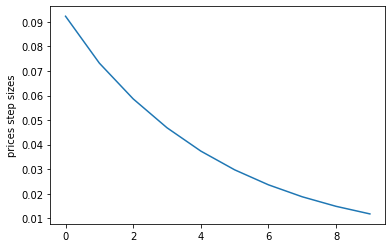

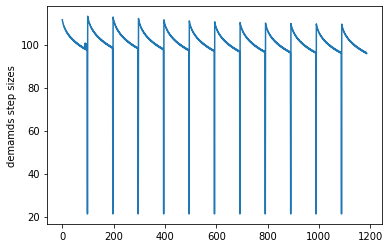

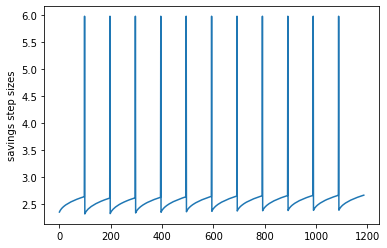

In [16]:
num_goods = 5
num_buyers = 5
num_samples = 25
discount = 0.9

valuations = np.array([[0.50722067, 0.76313337, 0.05360443, 0.7501781,  0.67800042],
 [0.2274455,  0.06174344, 0.39171342, 0.1402779,  0.15473259],
 [0.16527965, 0.3476444,  0.36241701, 0.99000073, 0.75359852],
 [0.34999164, 0.68091931, 0.0310125,  0.17069236, 0.03813618],
 [0.02829523, 0.34238797, 0.69479688, 0.45690191, 0.4699344 ]])


valuations = valuations / (np.sum(valuations))


num_iters_prices = 60
num_iters_demands = 100

value_coef = np.zeros(5)
value_intercept = 0


budgets = np.array([9.09845395, 9.18667045, 9.2, 10, 10])


utility_type = "leontief"


learn_rate_prices = 2
learn_rate_demands = 5e-5

print(learn_rate_prices)
print(learn_rate_demands)


prices_step_sizes, demands_step_sizes, savings_step_sizes = min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, 
                                                                                 discount, learn_rate_prices, learn_rate_demands, 
                                                                                num_iters_prices, num_iters_demands, utility_type, test=True)
plt.plot(prices_step_sizes[1:])
plt.ylabel("prices step sizes")
plt.show()

plt.plot(demands_step_sizes[1:])
plt.ylabel("demamds step sizes")
plt.show()

plt.plot(savings_step_sizes[1:])
plt.ylabel("savings step sizes")
plt.show()



## single_buyer_val_iter

In [17]:
def single_buyer_val_iter(budgets_samples, prices_list, buyer, valuations, gamma, slope, intercept, 
                          num_iters, num_samples, utility_type, fitted_value_coef, fitted_value_intercept):
    value_slope_hist = []
    value_intercept_hist = []
    values_hist = []
    budgets_hist = []

    if utility_type == "linear":
        get_max = get_max_linear
    elif utility_type == "leontief":
        get_max = get_max_leontief
    elif utility_type == "cd":
        get_max = get_max_cd

    value_slope = slope
    value_intercept = intercept
    value_slope_hist.append(value_slope)
    value_intercept_hist.append(value_intercept)
    num_buyers = valuations.shape[0]
    

    for iter in range(num_iters):
        print(f"-----------------------Iteration {iter}-------------------")
        values = []
        budget_list = []
        for index, budgets in enumerate(budgets_samples):
          print(f"___sample {index}___")
          value, demand, saving = get_max(budgets[buyer], valuations[buyer], prices_list[index], discount, value_slope, value_intercept)
          values.append(value)
          budget_list.append(budgets[buyer])
          print("buyer value:", value)
          print("buyer demands:", demand)

        values_hist.append(values)    
        budgets_hist.append(budget_list)
        print(budget_list)
        print(values)
        reg = linear_model.LinearRegression()
        reg.fit(np.array(budget_list).reshape(-1,1), np.array(values))
        value_slope = reg.coef_ # Update the slope
        value_intercept = reg.intercept_ # Update the intercept
        
        value_intercept_hist.append(value_intercept)
        value_slope_hist.append(value_slope)
        values_hist.append(values)
        budgets_hist.append(budgets)
        print("SLOPE", value_slope)
        print("INTERCEPT:", value_intercept)
    
    return value_slope, value_intercept, values_hist



## get_greedy_action

In [18]:
def get_greedy_action(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                                           learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands):
  value, prices, demands, savings =  min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False)

  return (prices, demands, savings)

## get_buyers_cumulative_util

In [19]:
def get_buyers_cumulative_util(init_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                               num_iters_prices, num_iters_demands, num_iters):
  
  if utility_type == "linear":
      get_util = get_linear_util
  elif utility_type == "leontief":
      get_util = get_leontief_util
  elif utility_type == "cd":
      get_util = get_cd_util
  
  num_buyers = valuations.shape[0]
  num_goods = valuations.shape[1]
  cumul_utils = np.zeros(num_buyers)
  excess_demands_hist = []
  budgets = init_budgets   
  for iter in range(num_iters):
    print(f"--------------------cumulative iter {iter}---------------------")
    print(f"budgets: {budgets}")
    prices, demands, savings = get_greedy_action(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                                           learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands)
    if iter == 0:
      start_prices = prices
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    excess_demands_hist.append(np.linalg.norm(excess_demands))
    print("util:", get_util(demands, valuations))
    cumul_utils += (discount**iter)*get_util(demands, valuations)
    ir = np.random.choice([0.9, 1.0, 1.1, 1.2, 1.5], 1, [0.2, 0.2, 0.2, 0.2, 0.2])
    print("interest rate:", ir)
    print("cumul util:", cumul_utils)
    budgets = ir * savings + np.ones(num_buyers) * 9.5

  return cumul_utils, excess_demands_hist


# Changes in Value Functions

## Plot

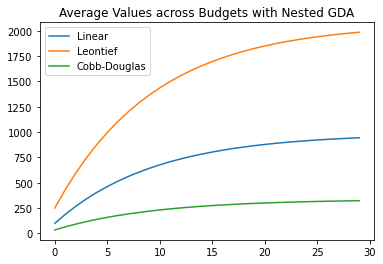

In [20]:
avg_values_linear = np.average(values_hist_linear, axis = 1) 
# avg_values_linear = avg_values_linear / np.sum(avg_values_linear)
avg_values_leontief = np.average(values_hist_leontief, axis = 1)
# avg_values_leontief = avg_values_leontief/ np.sum(avg_values_leontief)
avg_values_cd = np.average(values_hist_cd, axis = 1)
# avg_values_cd= avg_values_cd / np.sum(avg_values_cd)

fig, ax = plt.subplots()
ax.set_title('Average Values across Budgets with Nested GDA')
ax.plot(np.arange(0, avg_values_linear.shape[0]), avg_values_linear, label = "Linear")
ax.plot(np.arange(0, avg_values_leontief.shape[0]), avg_values_leontief, label = "Leontief")
ax.plot(np.arange(0, avg_values_cd.shape[0]), avg_values_cd, label = "Cobb-Douglas")
ax.legend()
fig.show()


# Distance to Utility Maximization

## Single_buyer_val_iter

In [22]:
discount = 0.9

slope = 0
intercept = 0

num_iters = 50
num_samples = 15
utility_type = "leontief"


fitted_value_coef = coef_hist_leontief[-1]
fitted_value_intercept = intercept_hist_leontief[-1]
print(fitted_value_coef)
print(fitted_value_intercept)

num_iters_prices = 50
num_iters_demands = 100


[2.11264917 2.79554348 1.86494906 2.24786745 2.22390327]
1778.6413439378764


##### Get budgets-prices pairs for value iterations

In [23]:
num_buyers = valuations.shape[0]
budgets_samples = np.random.uniform(9, 10, (num_samples, num_buyers))
prices_list = []
learn_rate_prices = 2
learn_rate_demands = 5e-5
for index, budgets in enumerate(budgets_samples):
    print(f"-------------------------Sample {index}--------------------------------")
    min_max_value, prices, demands, savings = min_max_linear_value_jax(budgets, valuations, fitted_value_coef, fitted_value_intercept, discount, 
                                                                      learn_rate_prices, learn_rate_demands,
                                                                      num_iters_prices, num_iters_demands, utility_type, test=False)
    prices_list.append(prices)

print(prices_list)

-------------------------Sample 0--------------------------------

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.008352515418374661
------------------------------------------------------------------
budgets: [9.36574724 9.50178587 9.18448868 9.97735187 9.09565933]
demands: [[0.19780527 0.20816977 0.1816594  0.20463573 0.19780527]
 [0.20084074 0.18830488 0.22499661 0.18927717 0.20084074]
 [0.19441653 0.1817799  0.1782024  0.22213444 0.19441653]
 [0.21093188 0.23828108 0.19505023 0.19951442 0.21093188]
 [0.19235331 0.17968442 0.21627337 0.18066711 0.19235331]]
savings: [0.00022429 0.0002349  0.00024104 0.00021429 0.00024832]
prices: [9.36584217 9.51276963 9.55436659 9.50137291 9.36584218]
value: 1798.6057
excess demands: [-0.00365226 -0.00377995 -0.00381799 -0.00377113 -0.00365226]
-------------------------Sample 1--------------------------------

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.00938061121357353
----------------------------------

##### Single buyer value iteration

In [24]:
slope = 0
intercept = 0
learned_slopes = []
learned_intercepts = []
cumul_utils_single = []
values_hists = []

for buyer in range(num_buyers):
  opt_value_slope, opt_value_intercept, values_hist = single_buyer_val_iter(budgets_samples, prices_list, buyer, valuations, discount, slope, intercept, num_iters, num_samples, 
                                                                                            utility_type, fitted_value_coef, fitted_value_intercept)
  print(f"cumul util: {opt_value_slope * budgets[buyer-1] + opt_value_intercept}")
  print(f"slope: {opt_value_slope}")
  print(f"intercept: {opt_value_intercept}")
  cumul_utils_single.append(opt_value_slope * budgets[buyer-1] + opt_value_intercept)
  values_hists.append(values_hist)
  learned_slopes.append(opt_value_slope)
  learned_intercepts.append(opt_value_intercept)

Streaming output truncated to the last 5000 lines.
buyer demands: [0.27952833 0.54383082 0.0247688  0.13632712 0.03045828]
___sample 2___
buyer value: 7.608898856351838
buyer demands: [0.2771108  0.53912743 0.02455458 0.13514807 0.03019486]
___sample 3___
buyer value: 7.857854133743696
buyer demands: [0.28617758 0.55676712 0.02535798 0.13956998 0.0311828 ]
___sample 4___
buyer value: 7.72373106661049
buyer demands: [0.28129291 0.54726385 0.02492516 0.13718771 0.03065055]
___sample 5___
buyer value: 7.51321201053114
buyer demands: [0.27362595 0.53234755 0.02424579 0.1334485  0.02981514]
___sample 6___
buyer value: 7.304727778839057
buyer demands: [0.2660331  0.51757543 0.023573   0.12974543 0.0289878 ]
___sample 7___
buyer value: 7.466876763958128
buyer demands: [0.27193845 0.52906448 0.02409626 0.1326255  0.02963126]
___sample 8___
buyer value: 7.270210973198212
buyer demands: [0.26477602 0.51512975 0.02346161 0.12913235 0.02885082]
___sample 9___
buyer value: 7.730628238485255
buyer d

##### Cumulative utils single

[34.62482231 97.49572041 36.35245002 75.19117663 47.64108511]


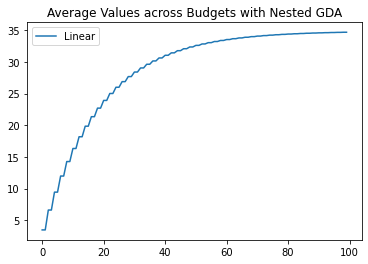

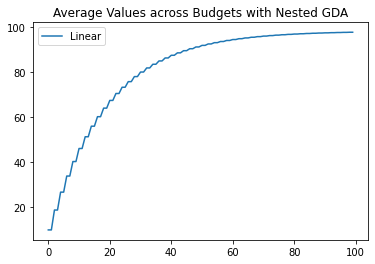

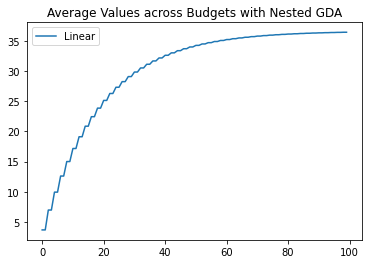

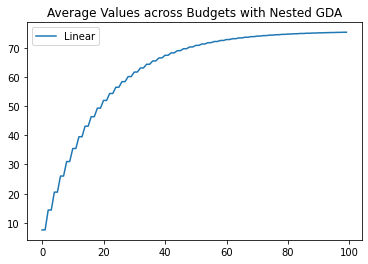

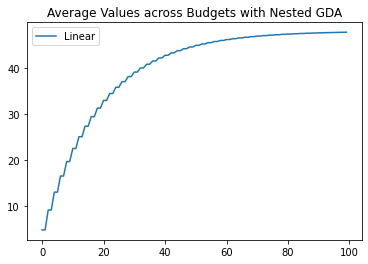

In [25]:
single_cumul_utils = np.array([util[0] for util in cumul_utils_single])
print(single_cumul_utils)

for values_hist in values_hists:
  avg_values = np.average(values_hist, axis = 1) 
# avg_values_linear = avg_values_linear / np.sum(avg_values_linear)


  fig, ax = plt.subplots()
  ax.set_title('Average Values across Budgets with Nested GDA')
  ax.plot(np.arange(0, avg_values.shape[0]), avg_values, label = "Linear")
  ax.legend()
  fig.show()

## Cumul_util all buyers

In [26]:
init_budgets = np.ones(num_buyers) * 10.0
print(fitted_value_coef)
print(fitted_value_intercept)
num_iters_prices = 60
num_iters_demands = 100
num_iters = 50
discount = 0.9
learn_rate_prices = 2
learn_rate_demands = 5e-5
utility_type = "leontief"
cumul_utils, excess_demands_hist =  get_buyers_cumulative_util(init_budgets, valuations, utility_type, fitted_value_coef, fitted_value_intercept, discount, learn_rate_prices, learn_rate_demands,
                               num_iters_prices, num_iters_demands, num_iters)

[2.11264917 2.79554348 1.86494906 2.24786745 2.22390327]
1778.6413439378764
--------------------cumulative iter 0---------------------
budgets: [10. 10. 10. 10. 10.]
Early end! Excess demand norm: 0.0035772163922455366
------------------------------------------------------------------
budgets: [10. 10. 10. 10. 10.]
demands: [[0.19937001 0.21088837 0.18321984 0.20720566 0.19937001]
 [0.19959441 0.18700046 0.22580704 0.18785589 0.19959441]
 [0.19980008 0.18720938 0.18365873 0.22961897 0.19980008]
 [0.19976063 0.22887735 0.18361851 0.18802468 0.19976063]
 [0.19959454 0.18700058 0.22580713 0.18785595 0.19959454]]
savings: [0.00023119 0.00024698 0.00023887 0.00024569 0.00024162]
prices: [ 9.89965014 10.0554278  10.09935805 10.04484627  9.89965014]
value: 1804.9326
excess demands: [-0.00188034  0.00097614  0.00211125  0.00056116 -0.00188034]
util: [2.65438098 5.53981245 2.22893955 3.23022816 3.12324335]
interest rate: [1.]
cumul util: [2.65438098 5.53981245 2.22893955 3.23022816 3.12324335]


In [27]:
print(excess_demands_hist)
print(np.mean(excess_demands_hist))

[0.0035772163922455366, 0.009250812218095228, 0.009250964949735428, 0.009250541707230024, 0.009250120534388714, 0.009251356705154682, 0.009248699440157207, 0.009248910215861876, 0.00925136206788142, 0.00925136894307639, 0.00925062518208247, 0.009251387816205886, 0.009250946655357637, 0.009251342370240605, 0.009250053840552266, 0.009250935428207908, 0.009251396922564199, 0.009248900906974335, 0.009250822155008432, 0.009250548035836637, 0.009250134106884541, 0.00925093827847381, 0.009250926379591618, 0.009250753078917855, 0.009251086558978631, 0.009248767941804539, 0.009250533320441017, 0.009251371588630949, 0.00925010595039175, 0.009250151221159082, 0.00925013186108577, 0.009250124510417805, 0.009250986861289943, 0.009251359645373703, 0.009250856301512135, 0.009250083644323292, 0.009251354416524873, 0.009250945830983702, 0.009250553106203327, 0.00925092859815751, 0.009250128649047291, 0.009255173606052967, 0.009250525130465878, 0.009250089198742147, 0.009248880507779696, 0.0092505301448

In [28]:
print(cumul_utils)

[26.25426417 54.59547307 21.98306801 31.84828502 30.77990489]


## Results

In [29]:
print(cumul_utils)
print(single_cumul_utils)

[26.25426417 54.59547307 21.98306801 31.84828502 30.77990489]
[34.62482231 97.49572041 36.35245002 75.19117663 47.64108511]


In [30]:
print(np.linalg.norm(cumul_utils-single_cumul_utils))
print(np.linalg.norm(cumul_utils-single_cumul_utils) / np.linalg.norm(single_cumul_utils))

65.4208090415116
0.46318382090712673
